<a href="https://colab.research.google.com/github/vkthakur90/Monte_Carlo_Option_Pricing/blob/main/Modern_Portfolio_Theory_(Linear_Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.linalg as la
import yfinance as yf
from datetime import datetime, timedelta

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
ticker_list = ["NIFTYBEES.NS", "GOLDBEES.NS"]

ar_p = 40 # Historical Lag
ar_h = 10  # Prediction Horizon

In [4]:
def download_data(entity, ticker_list):
    data_dict = {}

    for ticker in ticker_list:
        print(f"Downloading {ticker}")

        data = yf.download(ticker, period="10y", interval="1d")

        if data.index.tzinfo is None:
            data.index = data.index.tz_localize('UTC')

        data.index = data.index.tz_convert('Asia/Kolkata')

        data_dict[ticker] = pd.Series(data['Close'].values.reshape((-1,)), index = data.index)

    data_ = pd.DataFrame(data_dict)

    entity['data'] = data_

In [5]:
def compute_daily_log_return(entity):
    log_S = entity['data'].apply(np.log)
    prev_log_S = log_S.shift(1)
    entity['daily_log_return'] = 100 * (log_S - prev_log_S)

In [6]:
def split_data(entity):
    entity['train'] = entity['data'].iloc[:-ar_h]
    entity['test'] = entity['data'].iloc[-ar_h:]

    entity['daily_log_return_train'] = entity['daily_log_return'].iloc[:-ar_h]
    entity['daily_log_return_test'] = entity['daily_log_return'].iloc[-ar_h:]

In [7]:
def feature_engineering(entity):
    features_df = entity['daily_log_return_train']

    feature_dict = {}

    for column in features_df.columns:
        for idx in range(ar_p):
            feature_dict[f'{column}_m{idx + 1}'] = features_df[column].shift(idx + 1)

        for idx in range(ar_h):
            feature_dict[f'{column}_p{idx}'] = features_df[column].shift(-idx)

    entity['train_features'] = pd.DataFrame(feature_dict).dropna()

    X_cols = []
    for col in features_df.columns:
        X_cols += [f'{col}_m{idx + 1}' for idx in range(ar_p)]

    Y_cols = []
    for col in features_df.columns:
        Y_cols += [f'{col}_p{idx}' for idx in range(ar_h)]

    entity['train_x'] = entity['train_features'][X_cols]
    entity['train_y'] = entity['train_features'][Y_cols]
    entity['train_x'].eval('Intercept = 1', inplace = True)

In [8]:
def fit_linear_model(entity):
    params = la.inv(entity['train_x'].T @ entity['train_x']) @ (entity['train_x'].T @ entity['train_y'])
    params.index = entity['train_x'].columns

    entity['params'] = params

In [9]:
entity = {}
download_data(entity, ticker_list)
compute_daily_log_return(entity)
split_data(entity)
feature_engineering(entity)
fit_linear_model(entity)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


<Axes: >

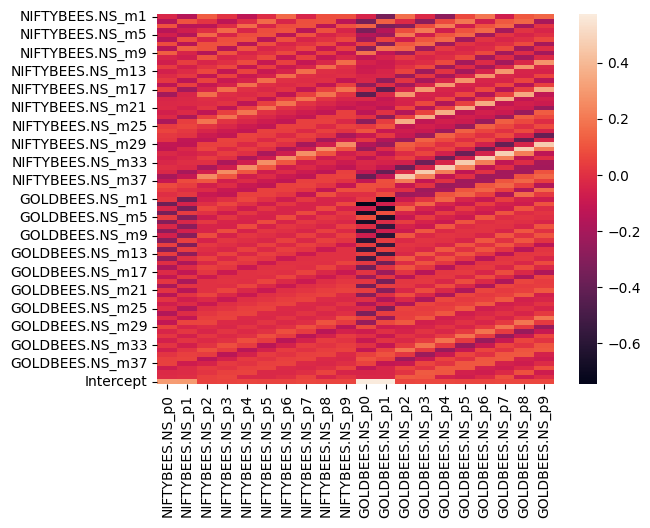

In [10]:
sns.heatmap(entity['params'])

<Axes: xlabel='Date', ylabel='NIFTYBEES.NS'>

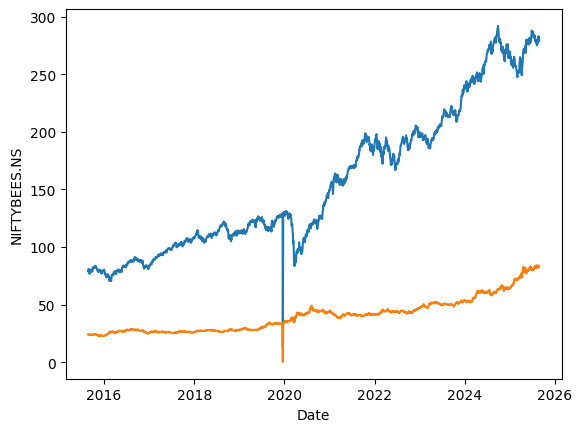

In [11]:
sns.lineplot(x = "Date", y = "NIFTYBEES.NS", data = entity["data"].reset_index())
sns.lineplot(x = "Date", y = "GOLDBEES.NS", data = entity["data"].reset_index())